$$L = MSE = \sum_{i=1}^{n}(y^{(i)} - y_{err}^{(i)})$$

$$\gamma = \arg \min_{\gamma} \sum_{i=1}^{n} L (y_i, F_{m-1}(x_i) + \gamma_m h_m(x))$$

чтобы найти минимум, приравняем $y$ и $F_{m-1}(x) + \gamma_m h_m(x)$

$$y = F_{m-1}(x) + \gamma_m h_m(x)$$

$$\gamma_m h_m(x) = y - F_{m-1}(x)$$

$$\gamma_m = {{y - F_{m-1}(x)} \over {h_m(x)}}$$

In [220]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import clone
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn .externals import six

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split

from copy import copy

import ipywidgets as widgets
from ipywidgets import interact


class ConstDummyEstimator:
    def __init__(self, const):
        self.const = np.array(const)
    
    def fit(self, X, y):
        ""
        
    def predict(self, X):
        return np.repeat(self.const, X.shape[0], axis=0)


class NewGradientBoost(BaseEstimator, RegressorMixin):
    def __init__(self, M=10, eta=1):
        self.M = M
        self.eta = eta
        
    def fit(self, X: np.ndarray, y: np.ndarray, visualize=False):
        
        if visualize:
            fig, ax = plt.subplots(self.M, 2, figsize=(10, 5 * self.M))
        
        # init with a mean (argmin of MSE)
        self.models_ = [ConstDummyEstimator(y.mean())]
        prev_pred = self.models_[0].predict(X).reshape(y.shape)
        self.gammas_ = [1]
        
        for i in range(self.M):
            ri = y - prev_pred
            
            if visualize:
                ax[i, 1].scatter(X, ri)
                ax[i, 1].set_ylim(-2, 2)
                ax[i, 1].plot([0, X.max()], [0, 0], c='k', linestyle='--')
            
            h = DecisionTreeRegressor(max_depth=1)
            
            h.fit(X, ri)
            
            grad = h.predict(X)
            
            grad = grad.reshape(y.shape)
            
            # gamma = (y / (prev_pred + grad)).mean()
            gamma = (ri / grad).mean()
            # gamma = (ri / grad)
            self.gammas_.append(gamma)
            
            # prev_pred += self.eta * grad
            hmgamma = gamma * grad
            hmgamma *= self.eta
            
            prev_pred += hmgamma
            
            if visualize:
                ax[i, 0].scatter(X, y, s=35)
                ax[i, 0].scatter(X, prev_pred, c='r')
            
            self.models_.append(h)
        
    def predict(self, X):
        prediction = self.models_[0].predict(X)
        
        for g, m in zip(self.gammas_[1:], self.models_[1:]):
            unscaled_pred = m.predict(X).reshape(prediction.shape)
            unscaled_pred *= g
            unscaled_pred *= self.eta
            
            prediction += unscaled_pred
            
        return prediction
    
    def get_params(self, deep=True):
        params = super(NewGradientBoost, self).get_params(deep=False)
        
        
        return params
        
    def score(self, X, y):
        # R2
        return r2_score(y, self.predict(X))

[1, 1.0, 0.9999999999999998, 1.0000000000000004, 0.9999999999999998, 1.0000000000000002, 1.0000000000000002, 1.0, 1.0, 1.0000000000000004, 1.0000000000000004, 0.9999999999999989, 1.0, 1.0, 0.9999999999999998, 1.0000000000000004]


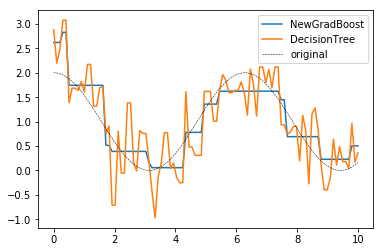

In [221]:
np.random.seed(0)

X = np.linspace(0, 10, 100)
y = np.cos(X)
y_denoised = copy(y) + 1

noise = np.random.normal(1, 0.5, (y.shape))
y += noise

X_train, X_test, y_train, y_test = train_test_split(X, y)

steps=15

wha = NewGradientBoost(M=steps, eta=1)
t = DecisionTreeRegressor(max_depth=steps)

wha.fit(X_train.reshape(-1, 1), y_train, visualize=False)
t.fit(X_train.reshape(-1, 1), y_train);

plt.plot(X, wha.predict(X.reshape(-1, 1)), label='NewGradBoost');
plt.plot(X, t.predict(X.reshape(-1, 1)), label='DecisionTree');
plt.plot(X, y_denoised, c='k', linestyle='--', linewidth=0.5, label='original')
plt.legend();

print(wha.gammas_)

In [222]:
np.random.seed(0)

X_v = np.linspace(0, 1, 100)
Y_v = np.linspace(0, 1, 100)

Z_v = (X_v + (Y_v + 2) * 2) ** 3

X = np.array((X_v, Y_v)).reshape(-1, 2)

y = Z_v

noise = np.random.normal(0, 0.5, (y.shape))
y_denoised = copy(y)
y += noise

X = np.concatenate((X_v.reshape(-1, 1), Y_v.reshape(-1, 1)), axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y)




elev_slider = widgets.FloatSlider(value=17, min=0, max=90, step=1)
azim_slider = widgets.FloatSlider(value=10, min=0, max=90, step=1)

eta_slider = widgets.FloatSlider(value=1, min=0, max=2, step=0.1)
m_slider = widgets.IntSlider(value=15, min=0, max=30)


bass = None
drop = None

prev_steps = None
prev_eta = None

def redraw(elev=0, azim=0, steps=15, eta=1):
    global bass
    global drop
    global prev_steps
    global prev_eta
    
    # refitting
    if steps != prev_steps or eta != prev_eta:
        prev_eta = eta
        prev_steps = steps
        
        bass = NewGradientBoost(M=prev_steps, eta=eta)
        drop = DecisionTreeRegressor(max_depth=prev_steps or 1)
        
        bass.fit(X_train, y_train)
        drop.fit(X_train, y_train)
        

    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')


    ax.plot(X_v, Y_v, y_denoised, c='k', linestyle='--');
    ax.plot(X_v, Y_v, np.zeros(y_denoised.shape), c='k', linewidth=0.5)
    ax.plot(X_v, np.zeros(Y_v.shape), y_denoised, c='k', linewidth=0.5)
    ax.plot(np.zeros(X_v.shape), Y_v, y_denoised, c='k', linewidth=0.5)
    
    ax.plot(X[:, 0], X[:, 1], bass.predict(X), c='r');
    ax.plot(X[:, 0], X[:, 1], np.zeros(bass.predict(X).shape), c='g', linewidth=0.3, alpha=0.5)
    ax.plot(X[:, 0], np.zeros(X[:, 1].shape), bass.predict(X), c='g', linewidth=0.5)
    ax.plot(np.zeros(X[:, 0].shape), X[:, 1], bass.predict(X), c='g', linewidth=0.5)

    ax.plot(X[:, 0], X[:, 1], drop.predict(X), c='orange');
    ax.plot(X[:, 0], X[:, 1], np.zeros(drop.predict(X).shape), c='y', linewidth=0.3, alpha=0.5)
    ax.plot(X[:, 0], np.zeros(X[:, 1].shape), drop.predict(X), c='y', linewidth=0.3)
    ax.plot(np.zeros(X[:, 0].shape), X[:, 1], drop.predict(X), c='y', linewidth=0.3)
    
    ax.view_init(elev=elev, azim=azim)
    
interact(redraw, elev=elev_slider, azim=azim_slider, steps=m_slider, eta=eta_slider);

interactive(children=(FloatSlider(value=17.0, description='elev', max=90.0, step=1.0), FloatSlider(value=10.0,…

In [208]:
print(bass.gammas_)

[1, 0.9999999999999998, 0.9999999999999997, 0.9999999999999998, 0.9999999999999998, 1.0, 1.0000000000000004, 1.0, 0.9999999999999997, 1.0, 1.0000000000000004, 1.0, 1.0, 1.0, 0.9999999999999997, 1.0, 1.0000000000000002, 1.0, 1.0, 0.9999999999999998, 0.9999999999999994, 1.0, 1.0000000000000004, 1.0, 1.0000000000000002, 1.0, 1.0, 1.0000000000000004, 0.9999999999999998, 1.0000000000000007, 1.0]
